# Imports

In [1]:
!pip install ../input/kerasapplications/keras-team-keras-applications-3b180cb -f ./ --no-index
!pip install ../input/efficientnet/efficientnet-1.1.0/ -f ./ --no-index

Looking in links: ./
Processing /kaggle/input/kerasapplications/keras-team-keras-applications-3b180cb
  Created wheel for Keras-Applications: filename=Keras_Applications-1.0.8-py3-none-any.whl size=50704 sha256=6a27a88f1abec0b7a8fc7e41979c88d49cfdfedeb0082707b0e795c9a752b428
  Stored in directory: /root/.cache/pip/wheels/f4/96/13/eccdd9391bd8df958d78851b98ec4dc207ba05b67b011eb70a
Successfully built Keras-Applications
Looking in links: ./
Processing /kaggle/input/efficientnet/efficientnet-1.1.0
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=14141 sha256=8c5f390dcea00718cfdc1b985b0d28e4431dd5f3c5427b24be67f6cf60327c0d
  Stored in directory: /root/.cache/pip/wheels/24/f5/31/3cc20871288fe532128224a3f5af7b4d67efb9835bd5683522
Successfully built efficientnet


In [2]:
import os
import cv2
import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import random
from tqdm.notebook import tqdm 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras import Model
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.optimizers import Nadam
import seaborn as sns
from PIL import Image

def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [4]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv') 

# Linear Decay (based on EfficientNets)

In [5]:
def get_tab(df):
    vector = [(df.Age.values[0] - 30) / 30] 
    
    if df.Sex.values[0] == 'male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector) 

In [6]:
A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p, :] 
    fvc = sub.FVC.values
    weeks = sub.Weeks.values
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


In [7]:
TAB

{'ID00007637202177411956430': array([1.63333333, 1.        , 1.        , 1.        ]),
 'ID00009637202177434476278': array([1.3, 1. , 1. , 1. ]),
 'ID00010637202177584971671': array([1., 1., 1., 1.]),
 'ID00011637202177653955184': array([1.4, 1. , 1. , 1. ]),
 'ID00012637202177665765362': array([1.16666667, 1.        , 0.        , 0.        ]),
 'ID00014637202177757139317': array([0.86666667, 1.        , 1.        , 1.        ]),
 'ID00015637202177877247924': array([1.36666667, 1.        , 1.        , 1.        ]),
 'ID00019637202178323708467': array([1.76666667, 1.        , 1.        , 1.        ]),
 'ID00020637202178344345685': array([1.2, 1. , 0. , 0. ]),
 'ID00023637202179104603099': array([1.36666667, 1.        , 1.        , 1.        ]),
 'ID00025637202179541264076': array([1.16666667, 1.        , 1.        , 1.        ]),
 'ID00026637202179561894768': array([0.9, 1. , 1. , 1. ]),
 'ID00027637202179689871102': array([1.43333333, 1.        , 1.        , 1.        ]),
 'ID000306372

## CNN for coeff prediction

In [8]:
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize(d.pixel_array / 2**11, (512, 512))

In [9]:
from tensorflow.keras.utils import Sequence

class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=32):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a

In [10]:
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, Conv2D, AveragePooling2D, 
    LeakyReLU, Concatenate 
)
import efficientnet.tfkeras as efn

def get_efficientnet(model, shape):
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False),
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(512, 512, 1), model_class=None):
    inp = Input(shape=shape)
    base = get_efficientnet(model_class, shape)
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    inp2 = Input(shape=(4,))
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x = Concatenate()([x, x2]) 
    x = Dropout(0.5)(x) 
    x = Dense(1)(x)
    model = Model([inp, inp2] , x)
    
    weights = [w for w in os.listdir('../input/osic-model-weights') if model_class in w][0]
#     model.load_weights('../input/osic-model-weights/' + weights)
    model.load_weights('../input/effnet-b5-30epochs-1/effnet_30.h5')
    return model

model_classes = ['b5'] #['b0','b1','b2','b3',b4','b5','b6','b7']
models = [build_model(shape=(512, 512, 1), model_class=m) for m in model_classes]
print('Number of models: ' + str(len(models)))

Number of models: 1


In [11]:
from sklearn.model_selection import train_test_split 

tr_p, vl_p = train_test_split(P, 
                              shuffle=True, 
                              train_size= 1) 

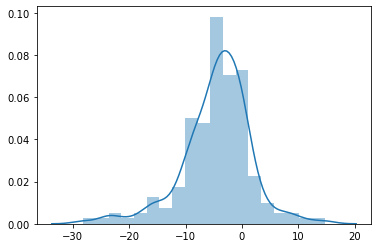

In [12]:
sns.distplot(list(A.values()));

In [13]:
def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 70) # changed from 70, trie 66.7 too
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)

In [14]:
subs = []
for model in models:

    q = 0.5

    sub = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv') 
    test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv') 
    A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
    STD, WEEK = {}, {} 
    for p in test.Patient.unique():
        x = [] 
        tab = [] 
        ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/')
        for i in ldir:
            if int(i[:-4]) / len(ldir) < 1.1 and int(i[:-4]) / len(ldir) > -0.1:
                x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/{i}')) 
                tab.append(get_tab(test.loc[test.Patient == p, :])) 
        if len(x) <= 1:
            continue
        tab = np.array(tab) 

        x = np.expand_dims(x, axis=-1) 
        _a = model.predict([x, tab]) 
        a = np.quantile(_a, q)
        A_test[p] = a
        B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
        P_test[p] = test.Percent.values[test.Patient == p] 
        WEEK[p] = test.Weeks.values[test.Patient == p]

    for k in sub.Patient_Week.values:
        p, w = k.split('_')
        w = int(w) 

        fvc = A_test[p] * w + B_test[p]
        sub.loc[sub.Patient_Week == k, 'FVC'] = fvc
        sub.loc[sub.Patient_Week == k, 'Confidence'] = (
            P_test[p] - A_test[p] * abs(WEEK[p] - w) 
    ) 

    _sub = sub[["Patient_Week","FVC","Confidence"]].copy()
    subs.append(_sub)

In [15]:
subs[0]

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3089.912209,140.099064
1,ID00421637202311550012437_-12,2843.369867,186.415158
2,ID00422637202311677017371_-12,1999.601912,146.274405
3,ID00423637202312137826377_-12,3405.996907,191.255810
4,ID00426637202313170790466_-12,2967.838420,114.663388
...,...,...,...
725,ID00419637202311204720264_133,2526.730523,563.456332
726,ID00421637202311550012437_133,2282.865025,538.180266
727,ID00422637202311677017371_133,1438.919843,567.752650
728,ID00423637202312137826377_133,2846.012371,527.246532


## Averaging Predictions

In [16]:
N = len(subs)
sub = subs[0].copy() # ref
sub["FVC"] = 0
sub["Confidence"] = 0
for i in range(N):
    sub["FVC"] += subs[0]["FVC"] * (1/N)
    sub["Confidence"] += subs[0]["Confidence"] * (1/N)

In [17]:
N

1

In [18]:
sub.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3089.912209,140.099064
1,ID00421637202311550012437_-12,2843.369867,186.415158
2,ID00422637202311677017371_-12,1999.601912,146.274405
3,ID00423637202312137826377_-12,3405.996907,191.255810
4,ID00426637202313170790466_-12,2967.838420,114.663388


In [19]:
sub[["Patient_Week","FVC","Confidence"]].to_csv("submission_img.csv", index=False)

In [20]:
img_sub = sub[["Patient_Week","FVC","Confidence"]].copy()

In [21]:
img_sub

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3089.912209,140.099064
1,ID00421637202311550012437_-12,2843.369867,186.415158
2,ID00422637202311677017371_-12,1999.601912,146.274405
3,ID00423637202312137826377_-12,3405.996907,191.255810
4,ID00426637202313170790466_-12,2967.838420,114.663388
...,...,...,...
725,ID00419637202311204720264_133,2526.730523,563.456332
726,ID00421637202311550012437_133,2282.865025,538.180266
727,ID00422637202311677017371_133,1438.919843,567.752650
728,ID00423637202312137826377_133,2846.012371,527.246532


# Osic-Multiple-Quantile-Regression

In [22]:
ROOT = "../input/osic-pulmonary-fibrosis-progression"
BATCH_SIZE=128

tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")

print("add infos")
sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

add infos


In [23]:
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])

In [24]:
print(tr.shape, chunk.shape, sub.shape, data.shape)
print(tr.Patient.nunique(), chunk.Patient.nunique(), sub.Patient.nunique(), 
      data.Patient.nunique())
#

(1535, 8) (5, 8) (730, 10) (2270, 10)
176 5 5 176


In [25]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [26]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [27]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [28]:
data

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,min_week,min_FVC,base_week
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,0.0
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,9.0
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,11.0
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,13.0
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2265,ID00426637202313170790466,129,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_129,0.0,2925,129.0
2266,ID00426637202313170790466,130,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_130,0.0,2925,130.0
2267,ID00426637202313170790466,131,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_131,0.0,2925,131.0
2268,ID00426637202313170790466,132,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_132,0.0,2925,132.0


In [29]:
COLS = ['Sex','SmokingStatus'] #,'Age'
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)

In [30]:
#
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['age','week','BASE']

In [31]:
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [32]:
tr.shape, chunk.shape, sub.shape

((1535, 22), (5, 22), (730, 22))

In [33]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")

def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

def make_model(nh):
    z = L.Input((nh,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
    #x = L.Dense(100, activation="relu", name="d3")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    #model.compile(loss=qloss, optimizer="adam", metrics=[score])
    model.compile(loss=mloss(0.8), optimizer=tf.keras.optimizers.Adam(lr=0.09, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model

In [34]:
y = tr['FVC'].values
z = tr[FE].values
ze = sub[FE].values
nh = z.shape[1]
pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))

In [35]:
net = make_model(nh)
print(net.summary())
print(net.count_params())

Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Patient (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
d1 (Dense)                      (None, 100)          900         Patient[0][0]                    
__________________________________________________________________________________________________
d2 (Dense)                      (None, 100)          10100       d1[0][0]                         
__________________________________________________________________________________________________
p1 (Dense)                      (None, 3)            303         d2[0][0]                         
________________________________________________________________________________________________

In [36]:
NFOLD = 2 # originally 5
kf = KFold(n_splits=NFOLD)

In [37]:
%%time
cnt = 0
EPOCHS = 700
for tr_idx, val_idx in kf.split(z):
    cnt += 1
    print(f"FOLD {cnt}")
    net = make_model(nh)
    net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS, 
            validation_data=(z[val_idx], y[val_idx]), verbose=0) #
    print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    print("val", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
    print("predict val...")
    pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
    print("predict test...")
    pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD

FOLD 1
train [45.42180252075195, 6.58517599105835]
val [56.82666015625, 6.788679599761963]
predict val...
predict test...
FOLD 2
train [50.09426498413086, 6.636465549468994]
val [51.11012268066406, 6.700071811676025]
predict val...
predict test...
CPU times: user 1min 11s, sys: 3.91 s, total: 1min 15s
Wall time: 1min 6s


In [38]:
pred

array([[2160.12109375, 2304.78442383, 2428.55664062],
       [2137.86083984, 2282.73657227, 2407.16748047],
       [2132.9140625 , 2277.83691406, 2402.4140625 ],
       ...,
       [2633.18994141, 2813.74707031, 2945.36010742],
       [2553.57861328, 2763.72998047, 2917.88354492],
       [2477.70532227, 2715.6484375 , 2891.16943359]])

In [39]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

154.9213054048122 257.8424310044279


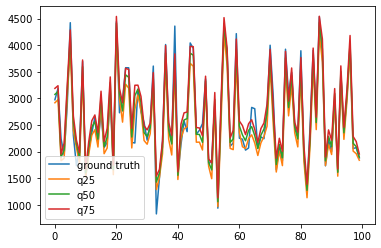

In [40]:
idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

In [41]:
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())

64.79833984375 257.8424310044279 465.8740234375 1.0


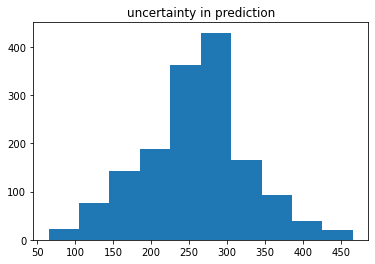

In [42]:
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()

In [43]:
sub.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent
1540,ID00419637202311204720264,-12,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-12,...,-18.0,1,0,1,0,0,0.615385,0.3724,0.067901,0.332421
1541,ID00419637202311204720264,-11,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-11,...,-17.0,1,0,1,0,0,0.615385,0.3724,0.074074,0.332421
1542,ID00419637202311204720264,-10,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-10,...,-16.0,1,0,1,0,0,0.615385,0.3724,0.080247,0.332421
1543,ID00419637202311204720264,-9,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-9,...,-15.0,1,0,1,0,0,0.615385,0.3724,0.086420,0.332421
1544,ID00419637202311204720264,-8,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-8,...,-14.0,1,0,1,0,0,0.615385,0.3724,0.092593,0.332421


In [44]:
# PREDICTION
sub['FVC1'] = 1.*pe[:, 1]
sub['Confidence1'] = pe[:, 2] - pe[:, 0]
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
yo=subm.loc[~subm.FVC1.isnull()]
subm.loc[~subm.FVC1.isnull()].head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,3020,100.0,3048.271851,211.014282
1541,ID00419637202311204720264_-11,3020,100.0,3044.119751,213.448853
1542,ID00419637202311204720264_-10,3020,100.0,3039.967163,215.883179
1543,ID00419637202311204720264_-9,3020,100.0,3035.814941,218.317505
1544,ID00419637202311204720264_-8,3020,100.0,3031.662842,220.751831


In [45]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
sigma_mean = 60
if sigma_mean<sigma_mean:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [46]:
subm.head()

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,3048.271851,211.014282,3048.271851,211.014282
1541,ID00419637202311204720264_-11,3044.119751,213.448853,3044.119751,213.448853
1542,ID00419637202311204720264_-10,3039.967163,215.883179,3039.967163,215.883179
1543,ID00419637202311204720264_-9,3035.814941,218.317505,3035.814941,218.317505
1544,ID00419637202311204720264_-8,3031.662842,220.751831,3031.662842,220.751831


In [47]:
subm.describe().T

,count,mean,std,min,25%,50%,75%,max
FVC,730.0,2608.833031,425.282760,1756.274658,2466.001373,2687.367920,2897.477203,3366.717407
Confidence,730.0,324.806948,64.441843,183.135742,280.547180,326.955872,381.889618,430.262207
FVC1,730.0,2608.833031,425.282760,1756.274658,2466.001373,2687.367920,2897.477203,3366.717407
Confidence1,730.0,324.806948,64.441843,183.135742,280.547180,326.955872,381.889618,430.262207


In [48]:
otest = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

In [49]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission_regression.csv", index=False)

In [50]:
reg_sub = subm[["Patient_Week","FVC","Confidence"]].copy()

In [51]:
reg_sub

,Patient_Week,FVC,Confidence
1540,ID00419637202311204720264_-12,3048.271851,211.014282
1541,ID00419637202311204720264_-11,3044.119751,213.448853
1542,ID00419637202311204720264_-10,3039.967163,215.883179
1543,ID00419637202311204720264_-9,3035.814941,218.317505
1544,ID00419637202311204720264_-8,3031.662842,220.751831
...,...,...,...
2265,ID00426637202313170790466_129,2614.786499,395.980225
2266,ID00426637202313170790466_130,2614.016968,396.195557
2267,ID00426637202313170790466_131,2613.248047,396.411133
2268,ID00426637202313170790466_132,2612.478760,396.626465


# Ensemble (Simple Blend)

In [52]:
df1 = img_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
df2 = reg_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)

In [53]:
df1

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-1,3047.188081,97.374936
1,ID00419637202311204720264_-10,3082.144186,132.331041
2,ID00419637202311204720264_-11,3086.028198,136.215053
3,ID00419637202311204720264_-12,3089.912209,140.099064
4,ID00419637202311204720264_-2,3051.072093,101.258948
...,...,...,...
725,ID00426637202313170790466_95,2585.862509,410.962459
726,ID00426637202313170790466_96,2582.292641,414.532327
727,ID00426637202313170790466_97,2578.722772,418.102196
728,ID00426637202313170790466_98,2575.152904,421.672064


In [54]:
actual=yo[['Patient_Week','FVC']]

In [55]:
main=actual.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)

In [56]:
main

,Patient_Week,FVC
0,ID00419637202311204720264_-1,3020
1,ID00419637202311204720264_-10,3020
2,ID00419637202311204720264_-11,3020
3,ID00419637202311204720264_-12,3020
4,ID00419637202311204720264_-2,3020
...,...,...
725,ID00426637202313170790466_95,2925
726,ID00426637202313170790466_96,2925
727,ID00426637202313170790466_97,2925
728,ID00426637202313170790466_98,2925


In [57]:
df = df1[['Patient_Week']].copy()
df['FVC'] = (0.45*df1['FVC'] + 0.55*df2['FVC'])
df['Confidence'] = (0.45*df1['Confidence'] + 0.55*df2['Confidence'])
df

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-1,3022.662810,174.604787
1,ID00419637202311204720264_-10,3058.946823,178.284717
2,ID00419637202311204720264_-11,3062.978552,178.693643
3,ID00419637202311204720264_-12,3067.010012,179.102434
4,ID00419637202311204720264_-2,3026.694405,175.013579
...,...,...,...
725,ID00426637202313170790466_95,2616.168122,398.690486
726,ID00426637202313170790466_96,2614.125817,400.421267
727,ID00426637202313170790466_97,2612.096268,402.146074
728,ID00426637202313170790466_98,2610.066719,403.870880


In [58]:
df.to_csv('submission.csv', index=False)

In [59]:
df.Confidence

0      174.604787
1      178.284717
2      178.693643
3      179.102434
4      175.013579
          ...    
725    398.690486
726    400.421267
727    402.146074
728    403.870880
729    405.595753
Name: Confidence, Length: 730, dtype: float64

In [60]:
def mainscore(actual_fvc, predicted_fvc, confidence, return_values = False):
    sd_clipped = np.maximum(confidence, 70)
    delta = np.minimum(np.abs(actual_fvc - predicted_fvc), 1000)
    metric = - np.sqrt(2) * delta / sd_clipped - np.log(np.sqrt(2) * sd_clipped)

    if return_values:
        return metric
    else:
        return np.mean(metric)


In [61]:
x=mainscore(main['FVC'],df['FVC'],df.Confidence)

In [62]:
x

-6.805057150362866